## Landmark based Faceregistration

**Goal**: The goal of this notebook is to implement the algorithms  for landmarks based registration.

We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) which is composed of several facial images annotated with 68 landmarks (already estimated and placed). Below, you will find a picture with an example. People express two emotions, either neutral or happy.

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
dest_path='./data/Data_FEI.npz')
gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
dest_path='./data/facial_landmarks_68markup.jpg')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA


Now, let's load the data. 

We have a list of images, the position of the landmarks (aligned to the images), the class labels Y (0 for neutral and 1 for happy) and the names of the images.

In [9]:
# Loading data
Working_directory="./data/" 
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    Landmarks = data['Landmarks_FEI'] # landmarks   
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = Landmarks.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

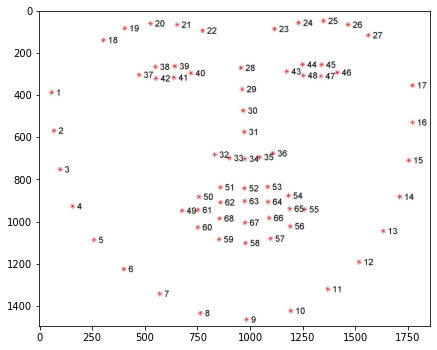

In [10]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (7,7)) # Size of the plot
plt.imshow(Example)
plt.show()

In [0]:
# Shuffle data randomly
indeces=np.arange(N) # Integers from 0 to N-1
np.random.shuffle(indeces)

#XpGPA=XGPA[indeces]
X=Landmarks[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]] 


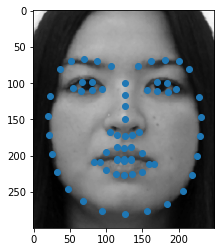

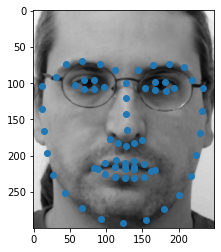

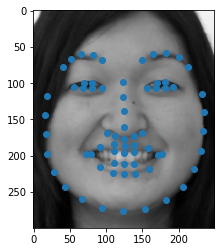

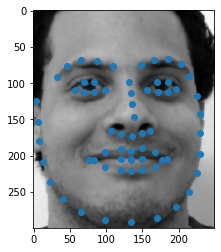

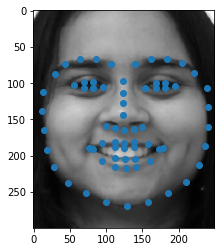

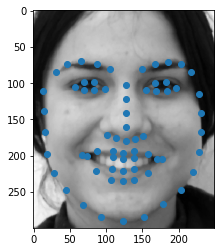

In [12]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

Now it's time to implement first the landmark based affine transformation and then the landmark based procrustes alignement (similarity transformation).
Please complete the code.

In [0]:
def AffineRegistrationLandmarks(x,y):
    
    '''
    Inputs: 
               x: [M,2] array containing the M 2-dim source landmarks
               y: [M,2] array containing the M 2-dim target landmarks
    
    Outputs:
               xp: [M,2] array containing the M 2-dim aligned source landmarks
               T: [3,3] transformation matrix
    
    '''

    if x.shape[0] != y.shape[0] or x.shape[1] != y.shape[1]:
        raise NameError('data should have the same dimensions')
        
    if x.shape[1] != 2:
        raise NameError('This code works only for 2 dimennsional data')        
        
    M=x.shape[0]
    
    X=np.zeros((2*M,6))
    X[:M,:2] = X[M:,3:5]=x
    X[:M,2]=X[M:,5]=np.ones(M)
    
    M1=(X.T).dot(np.ravel((y.T)).reshape(M*2,1))
    M2=np.dot(X.T,X)
    T= (LA.inv(M2)).dot(M1)
    xp=np.dot(X,T)
    xp=np.reshape(xp.T,x.shape,order='F')
       
    return xp,T


Let's test your implementation and see if it works.

[[ 1.00489122]
 [ 0.03603298]
 [-2.12710581]
 [-0.02199977]
 [ 1.10882532]
 [-5.82569279]]


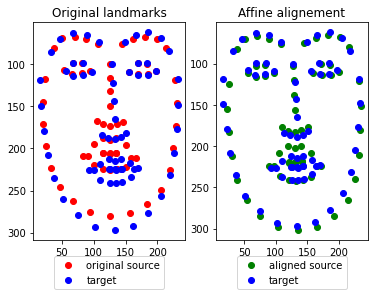

In [23]:
# Choose two random indeces between 0 and N-1
indexSource = 0
indexTarget = 399
dim=2
show_plot=1  
ls = X[indexSource] # source configuration
Is = Imagesp[indexSource,:,:] # image source
lt = X[indexTarget] # target configuration
It = Imagesp[indexTarget,:,:] # target image

# reshape landmarks configurations as matrices [M,2]
xs=np.reshape(ls,(M,dim))
xt=np.reshape(lt,(M,dim))

xpA,TA=AffineRegistrationLandmarks(xs,xt)
print(TA)

if show_plot==1:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.scatter(xs[:,0], xs[:,1], c='r',label='original source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Original landmarks')
    plt.subplot(1, 2, 2)
    plt.scatter(xpA[:,0], xpA[:,1], c='g',label='aligned source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Affine alignement')

Now, let's implement the procrustes alignement following the inputs and rules explained in the header of the function. 

In [0]:
def procrustes_align(x,y,mode='best',verbose=1):

    """ 
    Inputs: 
               X: [M,2] array containing the M 2-dim source landmarks
               Y: [M,2] matrix containing the M 2-dim target landmarks
               mode: 'rotation' to have only rotation, 'reflection' to
                   have only reflection and 'best' to have the one decided by the
                   data depending on det(U*V')
               verbose: 1 to have explanations and 0 otherwise
    
    Outputs:
               Xp: [M,2] array containing the aligned source landmarks
               s: uniform scaling
               R: rotation or reflection matrix
               t: translation vector
               SSR: sum of squared of residuals
               ratio_SSR: ratio of SSR with respect to the initial SSR
    
    """
    
    if mode.lower()!='best' and mode.lower()!='rotation' and mode.lower()!='reflection':
        raise NameError('Error ! mode should be equal to best, rotation or reflection')   
    
    if x.shape[0] != y.shape[0] or x.shape[1] != y.shape[1]:
        raise NameError('data should have the same dimensions')
        
    if x.shape[1] != 2:
        raise NameError('This code works only for 2 dimennsional data')        
        
    M=x.shape[0]
    
    # Center data
    xc=x-x.mean()
    yc=y-y.mean()
        
        
    # Optimal parameters
    U, D, Vt = np.linalg.svd(np.dot(xc.T,yc), full_matrices=True)
    
    if mode.lower() == 'rotation':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation. Computing rotation.')               
            S=np.eye(2) 
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection but a rotation is computed as requested.')               
            S=np.array([[1, 0], [0, np.linalg.det(U@Vt)]]) # to have det(U*V')=1
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    elif mode.lower() == 'reflection':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation but a reflection is computed as requested.')               
            S=np.array([[1, 0], [0, -np.linalg.det(U@Vt)]]) # to have det(U*V')=-1
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection. Computing reflection.')               
            S=np.eye(2)
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    elif mode.lower() == 'best':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation. Computing rotation.')               
            S=np.eye(2)
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection. Computing reflection.')               
            S=np.eye(2)
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
            
   
    R=U.dot(S.dot(Vt))
    s=S.dot(np.diag(D)).trace()/(xc.T.dot(xc)).trace()
    
    if mode.lower() == 'rotation':
        if np.absolute(np.linalg.det(R)-1)>1e-5:
            raise NameError('Error ! there is a problem...')
    if mode.lower() == 'reflection':
        if np.absolute(np.linalg.det(R)+1)>1e-5:
            raise NameError('Error ! there is a problem...')
            
    t = y.mean(axis=0)-(s/M)*((R.dot(x.T)).sum(axis=1))
    xp = (s*(R.dot(x.T))).T+t
    # Procrustes residuals
    SSR = np.sum(np.power((y-xp),2))
    
    # Ratio with initial residual
    SSR0 = np.sum(np.power((y-x),2))
    ratioSSR = SSR*100/SSR0
    
    return xp, s, R, t, SSR, ratioSSR

Let's test your implementation and see if it works.

The best R is a rotation. Computing rotation.


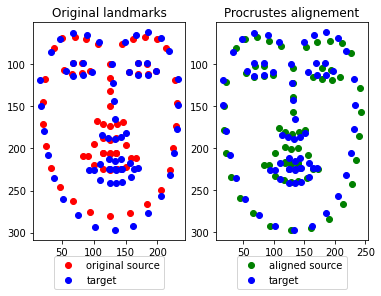

In [28]:
xp, s, R, t, SSR, ratioSSR = procrustes_align(xs,xt)

if show_plot==1:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.scatter(xs[:,0], xs[:,1], c='r',label='original source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Original landmarks')
    plt.subplot(1, 2, 2)
    plt.scatter(xp[:,0], xp[:,1], Sahar Boussoukaya Mana3rech elech 7assetha 3maylek Baya Cherif🤣🤣c='g',label='aligned source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Procrustes alignement')

Now, using the functions implemented in the previous jupyter-notebook, apply the transformation computed with the affine and/or procrustes alignement to the source image. 

**Question:** which warping should you use ?
**Answer:** Forward  Wrapping because we already know it is a rotation !

In [0]:
def applyTransformation(T, points=None, coords=None):
    ''' 
    Apply geometric transformation to points or image coordinates.
    Transformation is defined by a 3x3 matrix
        
    Inputs: 
        points: Nx2 Numpy array of points 
        coordinates: 2xNxM Numpy array of image coordinates
        T: 3x3 matrix trasformation
            
    Output:
        pm: Nx2 points after transformation
        cm: 2xNxM image coordinates after transformation
    ''' 
    if points is None and coords is None:
        raise ValueError("Error ! You should provide points and/or coords")
    
    if points is not None:    
        N,d = points.shape
        if d != 2 and N==2:
            print('WARNING ! points should be an array of dimension Nx2'+
                  ' Transposing the array')
            points=points.T
            N,d = points.shape
            
        if d != 2:
            raise ValueError("Error ! Function works only with 2D points")
            
        # Transform points into homogeneous coordinates (adding one...)
        points = np.vstack([points.T,np.ones((N,))])
        # Apply transformation
        pm = np.dot(T,points)
         # If homography, ...
        pm=(pm[:2,:]/pm[2,:]).T
    else:
        pm=None   
    if coords is not None:
        d,N,M = coords.shape
        
        if d != 2:
            raise ValueError("Error ! Function works only with 2D coordinates")
        
        p = coords.reshape((2,N*M)).T # reshape coordinates as list of points
        # Transform points into homogeneous coordinates (adding one...)
        p = np.vstack([p.T,np.ones((N*M,))])
        # Apply transformation
        pm = np.dot(T,p)
        # If homography, ...
        pm=pm[:2,:]/pm[2,:]
        cm = pm.reshape((2,N,M))     
    else:
        cm =None
                
    return pm,cm


In [0]:
def ForwardWarping(I,T,coords=None,outputShape=None):
    ''' 
    Apply forward warping to an image I based on a transformation T.
    Transformation is defined by a 3x3 matrix T
        
    Inputs: 
        I: image to transform
        T: 3x3 matrix trasformation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position
        outputShape: defines the shape of the transformed image.
                     It can be 'None', same shape as the input image I or 'BB', 
                     bounding box of the transformed image I_T,  or a tuple/numpy
                     array with 4 elements (min x, max x, min y, max y)
                    
    Output:
        J: transformed image
    ''' 

    if coords is None:
      coords = np.mgrid[0:I.shape[0], 0:I.shape[1]] # coordinates of the image I
      cm = applyTransformation(T,coords=coords)[1]

      if outputShape is None:
          outputShape=(0,I.shape[0],0,I.shape[1])
          
      elif outputShape == 'BB':
          #Find extremities bounding box
          bx=int(np.floor(np.min(cm[0,:,:])))
          ux=int(np.ceil(np.max(cm[0,:,:])))
          by=int(np.floor(np.min(cm[1,:,:])))
          uy=int(np.ceil(np.max(cm[1,:,:])))
          outputShape=(bx,ux,by,uy)
          
      elif isinstance(outputShape, tuple):
          if len(outputShape) != 4:
              raise ValueError("Error ! outputShape should be of length 4")           
              
      elif isinstance(outputShape, np.ndarray):
          if len(outputShape) != 4:
              raise ValueError("Error ! outputShape should be of length 4")                                      
      else:
          raise ValueError("Error ! outputShape should be None, 'BB' or a tuple/numpy array with 4 elements")       
                                
                              
      J= np.zeros((outputShape[1]-outputShape[0],outputShape[3]-outputShape[2]))  
      acc= np.zeros((outputShape[1]-outputShape[0],outputShape[3]-outputShape[2]))
      for i in range(I.shape[0]):
          for j in range(I.shape[1]):
              
              # transformed coordinate of a pixel
              p=cm[:,i,j]
              x=p[0]
              y=p[1]
              
              # Check if point is inside outputShape
              if (x>=outputShape[0] and x<=outputShape[1]-1 and y>=outputShape[2] and y<=outputShape[3]-1):
                            
                  # translate if necessary, since output image will start from (0,0)                         
                  # it basically shifts transformed points in the positive quadrant
                  if outputShape[0]<0:
                      x=x+abs(outputShape[0])
                      
                  if outputShape[2]<0:
                      y=y+abs(outputShape[2])   
                  
                # Look for the four corners
                  bl=(int(np.floor(x)),int(np.floor(y)))
                  br=(int(np.ceil(x)),int(np.floor(y)))
                  ul=(int(np.floor(x)),int(np.ceil(y)))
                  ur=(int(np.ceil(x)),int(np.ceil(y))) 
                
                  # Update J 
                  J[bl]+=I[i,j]
                  J[br]+=I[i,j]
                  J[ul]+=I[i,j]
                  J[ur]+=I[i,j]
                
                  # Update acc
                  acc[bl]+=1
                  acc[ul]+=1
                  acc[br]+=1
                  acc[ur]+=1
                  


      acc[acc==0]=1        
      J=np.divide(J,acc)
    
    else:
        raise ValueError("Error ! Still not implemented")
        
    return J

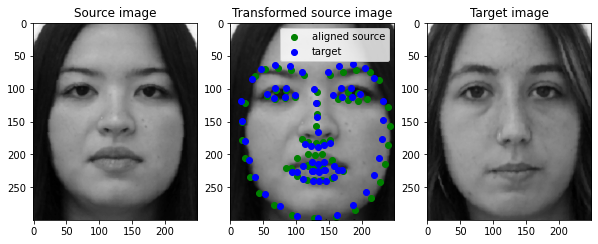

In [37]:
T=np.zeros((3,3))
T[2,2]=1
T[:2,:2]=s*R
T[:2,2]=t

Ism=ForwardWarping(Is,T,outputShape=None)

fig = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(Is, cmap='gray')
ax1.set_title('Source image')
ax2.imshow(Ism, cmap='gray')
ax2.set_title('Transformed source image')
ax3.imshow(It, cmap='gray')
ax3.set_title('Target image')
ax2.scatter(xp[:,0], xp[:,1], c='g',label='aligned source') 
ax2.scatter(xt[:,0], xt[:,1], c='b',label='target')
ax2.legend()
plt.show() 